<a href="https://colab.research.google.com/github/carlibeisel/mason_water_budget/blob/main/reach_precip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By Carli Beisel

Created August, 2024

Purpose: Calculates precipitation for each Reach within Mason Drainage from PRISM. Uses the surface area of drain segment within each Reach to calculate the actual direct input into the reach.

## Gridmet

In [ ]:
# Installs geemap package
!pip install pycrs
import subprocess

try:
    import geemap
except ImportError:
    print('geemap package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

# Checks whether this notebook is running on Google Colab
try:
    import google.colab
    import geemap.eefolium as emap
except:
    import geemap as emap

# Authenticates and initializes Earth Engine
try:
    import wxee
except ImportError:
    print('wxee package not installed. Installing...')
    subprocess.check_call(['python','-m','pip','install','wxee'])
  #!pip install eemont

import ee
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project = 'ee-tvirrigation')

from google.colab import drive
drive.mount('/content/gdrive')

import wxee
import os

Mounted at /content/gdrive


In [1]:
!pip install geopandas
import geopandas as gpd
import json
import os
import numpy as np
import pandas as pd
!pip install pycrs
import pycrs
import seaborn as sns
import matplotlib.pyplot as plt

#Connect to Google Drive if you want to export images
from google.colab import drive
drive.mount('/content/drive')

  Preparing metadata (setup.py) ... done
  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32687 sha256=f969ccce5e71fd041b9e3760982a016f8f3d443e516dd4d4260b3ee0f684120a
  Stored in directory: /root/.cache/pip/wheels/47/1d/70/7a5bdf33347e7c75e95b06b1fa38f076a59a9506653cc24aff
Successfully built pycrs
Mounted at /content/drive


In [ ]:
# Mason Drainage shapefile

shp_file = '/content/drive/MyDrive/Data/GIS Shapefiles/Mason Creek/Mason Creek.shp'
mason = emap.shp_to_ee(shp_file) # converts shapefile to feature in GEE

map = emap.Map(center=(43.6150, -116.2023),zoom=8)
map.addLayer(ee.Image().paint(mason, 0, 2), {})
map.addLayerControl()
map

Map(center=[43.615, -116.2023], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

In [ ]:
# ------------------------------------#
# Daily Precipitation in Mason Drainage
# ------------------------------------#

# units = mm

mason_precip = []
gridmet = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET').filterDate('2024-01-01', '2024-10-31')
gridmet_daily = gridmet.select('pr').map(lambda image: image.clip(mason))
mason_precip = gridmet_daily.toList(gridmet_daily.size())
mason_precip = ee.ImageCollection(mason_precip)
out_stats = os.path.join('/content/drive/MyDrive/Data/Mason Water Budget/data_input/precipitation/mason_precip_gridmet.csv')
emap.zonal_statistics(mason_precip, mason, out_stats, statistics_type='MEAN', scale=1000)

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Data/Mason Water Budget/data_input/precipitation/mason_precip_gridmet.csv


In [ ]:
# ------------------------------------#
# Clean up CSV File
# ------------------------------------#

df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_input/precipitation/mason_precip_gridmet.csv')
df = df.T.reset_index()
df.columns = ['Date', 'Precip (mm)']
df['Date'] = df['Date'].str.replace('_pr', '', regex=False)
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d', errors='coerce')
df['Precip (mm)'] = pd.to_numeric(df['Precip (mm)'], errors='coerce')
df['Precip (inches)'] = df['Precip (mm)'] * 0.0393701
df.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/precip_out/mason_precip.csv', index=False)

In [ ]:
# -------------------- #
# Export Monthly Precip
# -------------------- #

df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/precip_out/mason_precip.csv')
df['Date'] = pd.to_datetime(df['Date'])
df_monthly = df.resample('M', on='Date').sum(numeric_only=True)
df_monthly.index = df_monthly.index.strftime('%Y-%m')
df_monthly.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/precip_out/final_monthly_precip.csv')

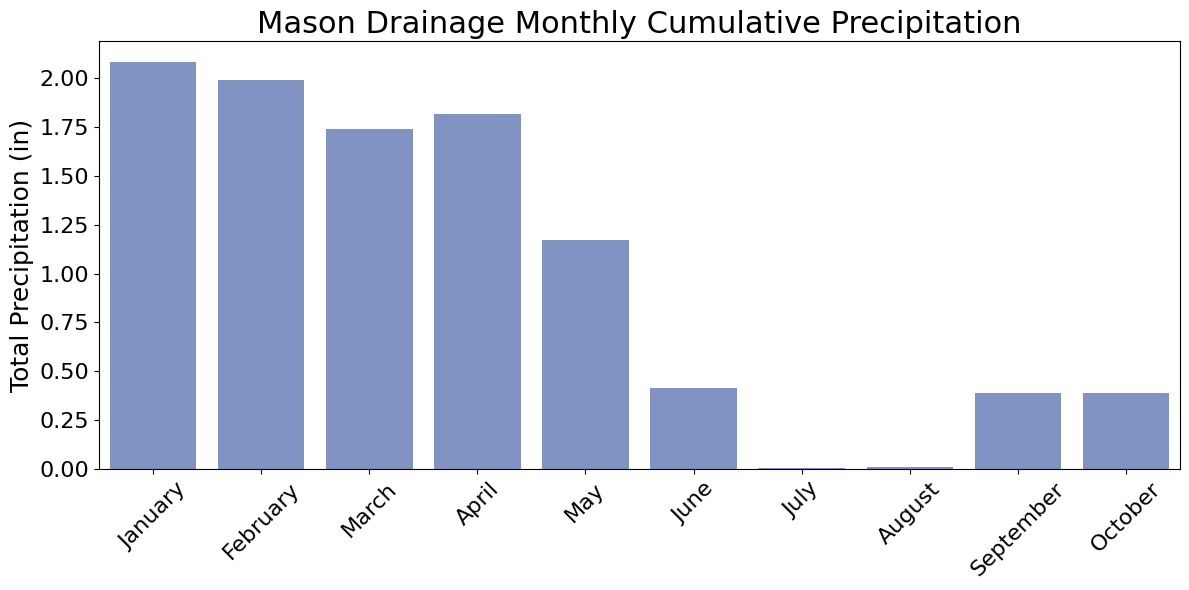

In [ ]:
# ----- #
# Plot #
# ----- #

df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/precip_out/mason_precip.csv')

# Ensure the Date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Group by year and month, and sum the precipitation for each month
df_monthly = df.resample('M', on='Date').sum(numeric_only=True)

# Add a 'Month' column with month names
df_monthly['Month'] = df_monthly.index.strftime('%B')

# Plotting the monthly total precipitation with month names on the x-axis
plt.figure(figsize=(12, 6))
sns.barplot(data=df_monthly.reset_index(), x='Month', y='Precip (inches)', color = '#758ECD')
plt.title('Mason Drainage Monthly Cumulative Precipitation', fontsize = 22)
plt.xlabel('')
plt.ylabel('Total Precipitation (in)', fontsize = 18)
plt.yticks(fontsize = 16)
plt.xticks(rotation=45, fontsize = 16)
plt.tight_layout()
plt.show()
plt.savefig('/content/drive/MyDrive/Data/Mason Water Budget/data_output/precip_out/mason_precip_plot.png', dpi=300, bbox_inches='tight')
plt.close()

In [ ]:
# ---------------------------------------- #
# Calculate monthly precip for each Reach
# ---------------------------------------- #
precip = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/precip_out/reach_precip_monthly.csv')

precip['Daymet Precip (ft)'] = precip['Precip (in)'] / 12

# Calculate the total monthly precipitation volume in cubic feet
precip['Total Monthly Precip (cubic ft)'] = precip['Daymet Precip (ft)'] * precip['Surface Area (ft^2)']

# Convert cubic feet to AF
precip['Total Monthly Precip (AF)'] = precip['Total Monthly Precip (cubic ft)'] / 43560
precip.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/precip_out/reach_precip_monthly.csv', index=False)

<ipython-input-13-b836da715f9e>:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-13-b836da715f9e>:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-13-b836da715f9e>:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-13-b836da715f9e>:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-13-b836da715f9e>:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-13-b836da715f9e>:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


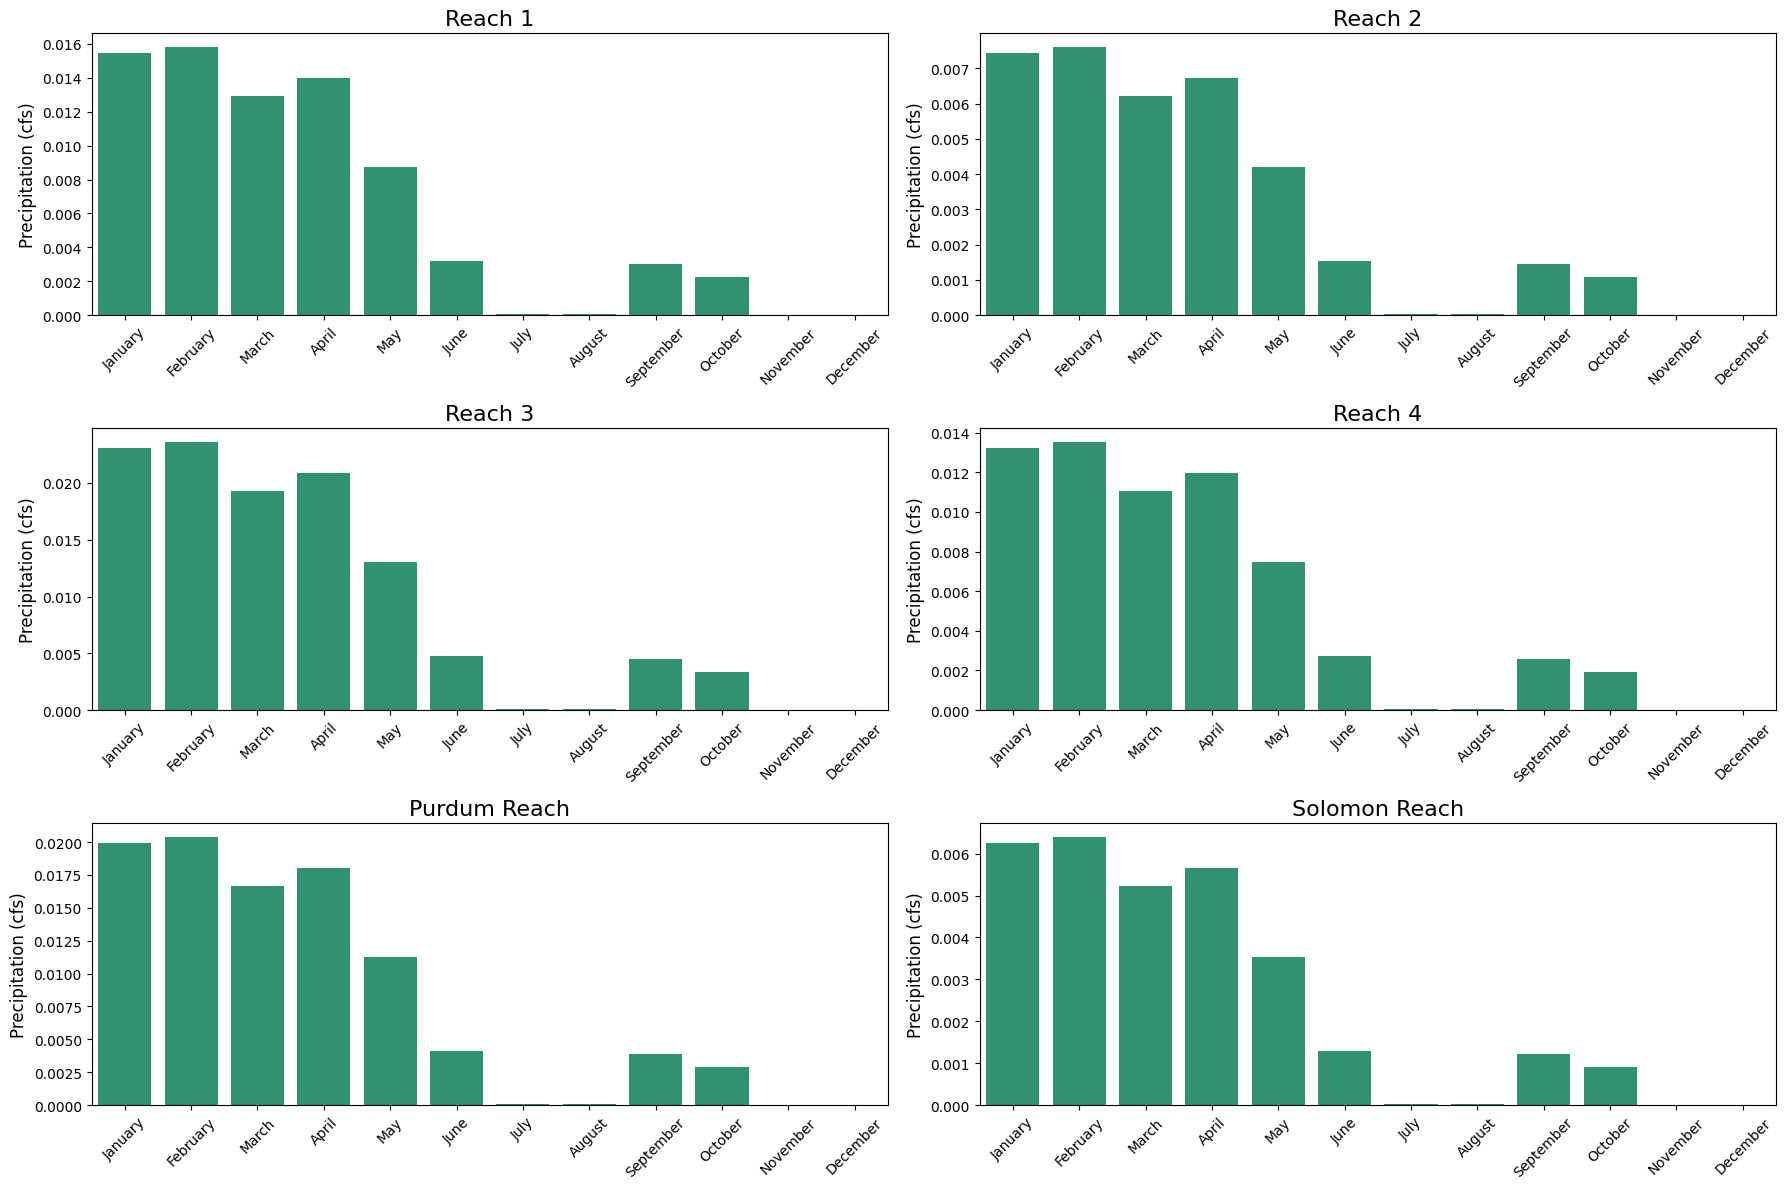

In [13]:
# --------------------- #
# Figure of Reach Precip
# --------------------- #

precip = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/precip_out/reach_precip_monthly.csv')

# Extract the month and calculate the number of days in each month
precip['Date'] = pd.to_datetime(precip['Month'], format='%Y-%m')
precip['Days in Month'] = precip['Date'].dt.days_in_month

# Convert AF to cfs
precip['Total Monthly Precip (cfs)'] = (precip['Total Monthly Precip (AF)'] * 43560) / (precip['Days in Month'] * 86400)

# Extract full month names for plotting
precip['Month'] = precip['Date'].dt.strftime('%B')

# Define the order of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']


reaches = precip['Reach'].unique()

# Create a 3x2 panel (6 plots)
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
axes = axes.flatten()

# plot each reach
for i, reach in enumerate(reaches):
    if i < len(axes):
        ax = axes[i]
        sns.barplot(
            data=precip[precip['Reach'] == reach],
            x='Month', y='Total Monthly Precip (cfs)', color='#21A179', ci=None, ax=ax,
            order=month_order
        )
        ax.set_title(reach, fontsize=16)
        ax.set_xlabel('')
        ax.set_ylabel('Precipitation (cfs)', fontsize=12)
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        ax.tick_params(axis='y', labelsize=10)

for j in range(len(reaches), len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()

output_path = '/content/drive/MyDrive/Data/Mason Water Budget/data_output/precip_out/reach_monthly_precip_cfs_panel.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()